In [1]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

C:\Users\user\AppData\Roaming\Python\Python37\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.8' currently installed).
  warnings.warn(msg, UserWarning)


In [160]:
from sklearn.metrics import f1_score, classification_report, accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve
import seaborn as sns

In [3]:
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [33]:
TARGET_VAR = 'failure'
RANDOMSEED = 42

# Load data

In [7]:
filename_ls = os.listdir('data')
filename_ls

['model_2015_ST4000DM000.csv',
 'model_2016_ST4000DM000.csv',
 'model_2017_ST4000DM000.csv',
 'model_2018_ST4000DM000.csv',
 'raw_combined.pickle']

In [92]:
raw_df_ls = [pd.read_csv(f'data/{filename}', delimiter=',') for filename in filename_ls]
[df.shape for df in raw_df_ls]

: 

In [ ]:
# extra columns in 2018 data
extra_cols= set(raw_df_ls[3].columns) - set(raw_df_ls[2].columns)
extra_cols

{'smart_177_normalized',
 'smart_177_raw',
 'smart_179_normalized',
 'smart_179_raw',
 'smart_181_normalized',
 'smart_181_raw',
 'smart_182_normalized',
 'smart_182_raw',
 'smart_235_normalized',
 'smart_235_raw'}

In [ ]:
# Drop columns only in 2018
raw_df_ls[3].drop(list(extra_cols), axis=1, inplace=True)

In [ ]:
[df.shape for df in raw_df_ls]

[(1243993, 95), (1076071, 95), (178298, 95), (380078, 95)]

In [ ]:
[df.date.agg(['min', 'max']) for df in raw_df_ls]


[min    2015-01-01
 max    2015-12-31
 Name: date, dtype: object, min    2016-01-01
 max    2016-09-30
 Name: date, dtype: object, min    2017-10-01
 max    2017-12-31
 Name: date, dtype: object, min    2018-01-01
 max    2018-12-31
 Name: date, dtype: object]

In [ ]:
df_raw = pd.concat(raw_df_ls, sort=True)
df_raw.shape

(2878440, 95)

In [8]:
COMBINED_RAW_PATH = 'data/raw_combined.pickle'

In [6]:
# # Save
# df_raw.to_pickle(COMBINED_RAW_PATH)

# Load
df_raw = pd.read_pickle(COMBINED_RAW_PATH)

In [9]:
df_raw.shape

(2878440, 95)

# Target distribution
4.4% failure rate - unbalanced

In [ ]:
df_raw.failure.value_counts('pct')

0    0.955247
1    0.044753
Name: failure, dtype: float64

In [ ]:
df_raw.failure.value_counts()

0    2749620
1     128820
Name: failure, dtype: int64

# Data quality

In [10]:
missing_values = df_raw.isna().sum()
cols_all_missing = list(missing_values.loc[missing_values==len(df_raw)].index)

num_unique_values = df_raw.nunique()
cols_single_value = list(num_unique_values.loc[num_unique_values==1].index)


In [11]:
# remove columns with all missing rows or constant value
drop_cols = list(set(cols_all_missing +  cols_single_value))
df_main = df_raw.copy().drop(drop_cols, axis=1)

In [12]:
# remove columns not useful as features
non_feature_cols = ['date', 'capacity_bytes', 'serial_number']
df_input = df_main.copy().drop(non_feature_cols, axis=1)

# EDA

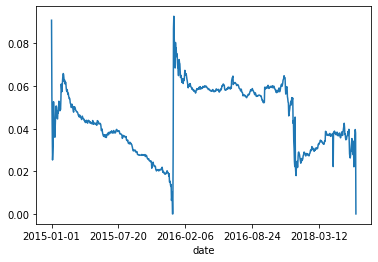

In [40]:
# failure rate over time
df_main.groupby('date').failure.mean().plot()

Elevated failure rate observed in 2016

In [ ]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    # filename = df.dataframeName
    # df = df.dropna('columns') # drop columns with NaN
    # df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    # if df.shape[1] < 2:
    #     print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
    #     return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    # plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()

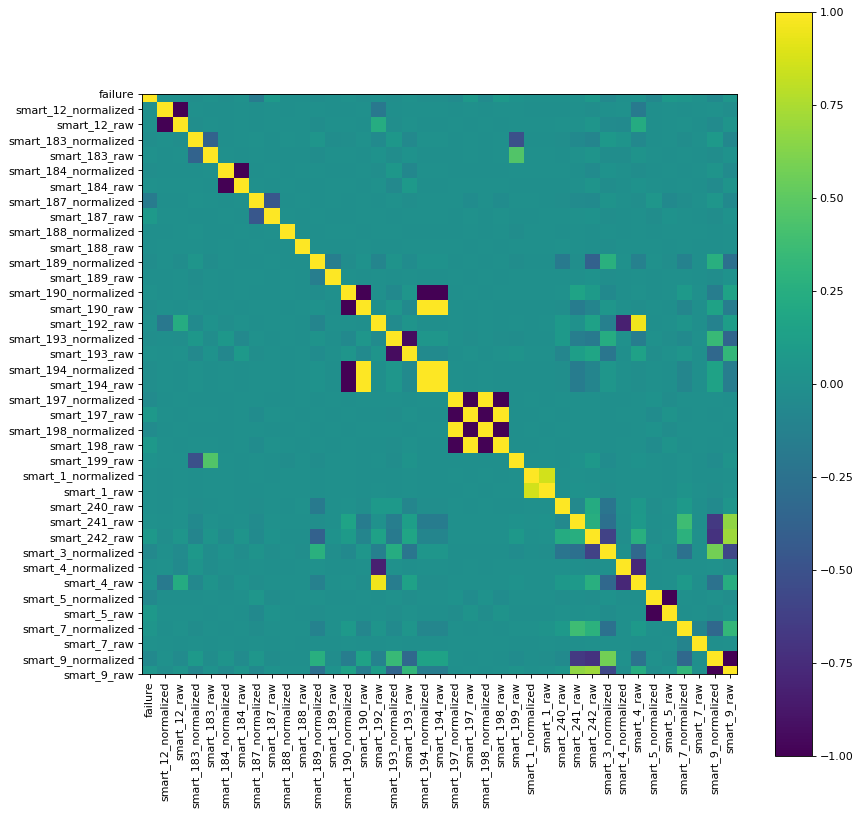

In [87]:
plotCorrelationMatrix(df_input, 12)

* 194 raw/normalised and 190 raw/normalised are perfectly correlated - consider dropping one or the other
* 4 raw/normalised and 192_raw are perfectly corelated - consider dropping one or the other
* missing values need imputation 

## Create train test data

In [ ]:
# feat_cols = [col for col in df_input.columns if col not in TARGET_VAR]
feat_cols = [col for col in feat_cols if col.endswith("_raw")]
X = df_input[feat_cols]
y = df_input[TARGET_VAR]

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOMSEED, stratify=y)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2302752, 38) (575688, 38) (2302752,) (575688,)


# Train model

In [47]:
# Define transformers
scaler = StandardScaler()
missing_imputer = SimpleImputer(strategy='mean')
numeric_transformer = Pipeline(steps=[
    ("imputer", scaler),
    ("scaler", missing_imputer )
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, feat_cols)
    ]
)

# Define model
rf = RandomForestClassifier(
    random_state=RANDOMSEED,
    n_jobs=-1,
    n_estimators=100
    )

# Define pipeline
clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", rf)
])

In [68]:
# Fit pipeline
clf.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('imputer', StandardScaler(copy=True, with_mean=True, with_std=True)), ('scaler', SimpleImputer(copy=True...imators=100, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False))])

# Evaluate

In [79]:
# Predict
y_prob = clf.predict_proba(X_test)[:, 1]
y_pred = clf.predict(X_test)

In [190]:
print(f"Area under the curve: {roc_auc_score(y_true=y_test, y_score=y_prob)}")

print(f"Classification report:\n {classification_report(y_true=y_test, y_pred=y_pred)}")

Area under the curve: 0.9996267156840002
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    549924
           1       1.00      0.92      0.96     25764

   micro avg       1.00      1.00      1.00    575688
   macro avg       1.00      0.96      0.98    575688
weighted avg       1.00      1.00      1.00    575688



In [156]:
def pretty_confusion_matrix(**args):
    # df =  args['df']
    cf_matrix = confusion_matrix(args['y_true'], args['y_pred'])
    group_names = ["True Neg", "False Pos", "False Neg", "True Pos"]
    group_counts = ["{0:0.0f}".format(val) for val in cf_matrix.flatten()]
    group_pct = ["{0:.2%}".format(val) for val in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{val1}\n{val2}\n{val3}" for val1, val2, val3 in zip(group_names, group_counts, group_pct)]
    labels = np.asarray(labels).reshape(2,2)

    plt.figure(figsize=(6,6))
    plot = sns.heatmap(cf_matrix, fmt='', annot=labels, cmap="Blues", xticklabels=["Good", "Fail"], yticklabels=["Good", "Fail"], cbar=False)
    bottom, top = plot.get_ylim()
    plot.set_ylim(bottom + 0.5, top-0.5)

    plt.ylabel("y_true")
    plt.xlabel("y_pred")
    # return plot

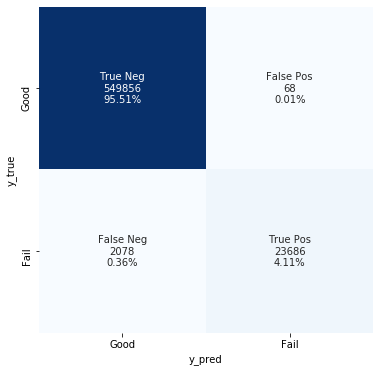

In [157]:
pretty_confusion_matrix(y_true=y_test, y_pred=y_pred)

# Train with cross validation to find best params

In [167]:
from collections import Counter
weight_factor = Counter(y_train)[0] /  Counter(y_train)[1]
weight_factor

21.344666977177457

In [171]:
# Define xgb pipeline
xgb = XGBClassifier(
    random_state=RANDOMSEED,
    n_jobs=-1
    )

# Define pipeline
clf_xgb = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", xgb)
])

In [179]:
params = {
    "classifier__n_estimators": [50, 100],
    "classifier__max_depth": [3, 5],
    "classifier__learning_rate": [0.05, 0.1],
    "classifier__scale_pos_weight": [1, weight_factor],
}

# define Randomsearch
cv = GridSearchCV(
    clf_xgb,
    params,
    cv=5,
    scoring='roc_auc',
    verbose=3
    )

In [184]:
# perform gridsearch
cv.fit(X_train.head(100000), y_train.head(100000))

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] classifier__learning_rate=0.05, classifier__max_depth=3, classifier__n_estimators=50, classifier__scale_pos_weight=1 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  classifier__learning_rate=0.05, classifier__max_depth=3, classifier__n_estimators=50, classifier__scale_pos_weight=1, score=0.6967644267104744, total=   3.8s
[CV] classifier__learning_rate=0.05, classifier__max_depth=3, classifier__n_estimators=50, classifier__scale_pos_weight=1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.0s remaining:    0.0s


[CV]  classifier__learning_rate=0.05, classifier__max_depth=3, classifier__n_estimators=50, classifier__scale_pos_weight=1, score=0.696433075593413, total=   3.4s
[CV] classifier__learning_rate=0.05, classifier__max_depth=3, classifier__n_estimators=50, classifier__scale_pos_weight=1 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.9s remaining:    0.0s


[CV]  classifier__learning_rate=0.05, classifier__max_depth=3, classifier__n_estimators=50, classifier__scale_pos_weight=1, score=0.692566414727232, total=   3.3s
[CV] classifier__learning_rate=0.05, classifier__max_depth=3, classifier__n_estimators=50, classifier__scale_pos_weight=1 
[CV]  classifier__learning_rate=0.05, classifier__max_depth=3, classifier__n_estimators=50, classifier__scale_pos_weight=1, score=0.7076067219084401, total=   3.3s
[CV] classifier__learning_rate=0.05, classifier__max_depth=3, classifier__n_estimators=50, classifier__scale_pos_weight=1 
[CV]  classifier__learning_rate=0.05, classifier__max_depth=3, classifier__n_estimators=50, classifier__scale_pos_weight=1, score=0.7048862403264948, total=   3.6s
[CV] classifier__learning_rate=0.05, classifier__max_depth=3, classifier__n_estimators=50, classifier__scale_pos_weight=21.344666977177457 
[CV]  classifier__learning_rate=0.05, classifier__max_depth=3, classifier__n_estimators=50, classifier__scale_pos_weight=21

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:  8.8min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('imputer', StandardScaler(copy=True, with_mean=True, with_std=True)), ('scaler', SimpleImputer(copy=True...
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'classifier__n_estimators': [50, 100], 'classifier__max_depth': [3, 5], 'classifier__learning_rate': [0.05, 0.1], 'classifier__scale_pos_weight': [1, 21.344666977177457]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=3)

In [187]:
print(cv.best_params_)
print(cv.best_score_)

{'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 100, 'classifier__scale_pos_weight': 21.344666977177457}
0.788213254338241


# Evaluate

In [188]:
# Predict with best estimator
y_prob_cv = cv.best_estimator_.predict_proba(X_test)[:, 1]
y_pred_cv = cv.best_estimator_.predict(X_test)

In [191]:
print(f"Area under the curve: {roc_auc_score(y_true=y_test, y_score=y_prob_cv)}")

print(f"Classification report:\n {classification_report(y_true=y_test, y_pred=y_pred_cv)}")

Area under the curve: 0.800084572151253
Classification report:
               precision    recall  f1-score   support

           0       0.98      0.80      0.88    549924
           1       0.13      0.63      0.21     25764

   micro avg       0.79      0.79      0.79    575688
   macro avg       0.55      0.72      0.55    575688
weighted avg       0.94      0.79      0.85    575688



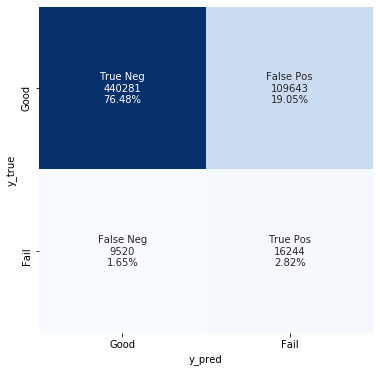

In [192]:
pretty_confusion_matrix(y_true=y_test, y_pred=y_pred_cv)